In [1]:
import os
import sys

repository_dir = os.path.realpath(os.path.join(os.getcwd(), '..','..','..'))
util_dir = os.path.join(repository_dir, 'utils')

sys.path.append(util_dir)

In [2]:
from workers import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
plt.style.use('seaborn')

In [41]:
def quotedate_contract(df, start, end, splitdate=None, splitratio=None):
    """
    get contracts with quotedate within start and end
    """
    output = df.copy()
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    quotedate = output['quotedate']
    
    if splitdate is not None:
        splitdate = pd.to_datetime(splitdate)
        output.loc[quotedate < splitdate, 'underlying_last'] /= splitratio
        output.loc[quotedate < splitdate, 'volume'] *= splitratio
    
    index = (quotedate >= start) & (quotedate <= end)
    
    return output[index]
    
def monthly_contract(df):
    """
    return 3 types of monthly contract: expire in current/next/3rd month
    """
    expiration, quotedate = df['expiration'], df['quotedate']
    expr_month = expiration.dt.year * 12 + expiration.dt.month
    quote_month = quotedate.dt.year * 12 + quotedate.dt.month
    
    third_friday = (expiration.dt.day >=15) & (expiration.dt.day <= 21) & (expiration.dt.weekday == 4)
    cur_month_expr =  expr_month == quote_month
    next_month_expr = expr_month - quote_month == 1
    third_month_expr = expr_month - quote_month == 2

    return df[third_friday&cur_month_expr], df[third_friday&next_month_expr], df[third_friday&third_month_expr]

def integer_strike_contract(df):
    """
    return contract whose strike is multiple of 10
    """
    strike = df['strike']
    int_strike = strike % 10 == 0

    return df[int_strike]

def moneyness_contract(df, atm_delta=[0.4,0.6], otm_delta=0.4, itm_delta=0.6):
    moneyness = ['atm','otm','itm']
    delta = df['delta']
    atm = df[(abs(delta) >= atm_delta[0]) & (abs(delta) <= atm_delta[1])]
    otm = df[abs(delta) < otm_delta]
    itm = df[abs(delta) > itm_delta]
    
    return atm, otm, itm
    
def pcratio(df):
    """
    return put-call ratio by date
    """
    ratio = df[df['type']=='put'].groupby('quotedate')['volume'].sum() / df[df['type']=='call'].groupby('quotedate')['volume'].sum()
    return ratio
    
def plot_by_moneyness(df, atm_delta=[0.4,0.6], otm_delta=0.4, itm_delta=0.6, _type='call', 
                      groupby='quotedate', variable = ['impliedvol','volume','openinterest'], style='scatter',title='None'):
    """
    plot n*3 graphs, n variables * 3 moneyness
    """
    atm, otm, itm = moneyness_contract(df, atm_delta, otm_delta, itm_delta)
    
    op = {'impliedvol':'mean', 'volume':'max', 'openinterest':'mean','underlying_last':'mean','delta':'mean'}
    grouped0 = atm[atm['type']==_type].groupby(groupby).agg(op)
    grouped1 = otm[otm['type']==_type].groupby(groupby).agg(op)
    grouped2 = itm[itm['type']==_type].groupby(groupby).agg(op)
    if 'pcratio' in variable:
        grouped0['pcratio'] = pcratio(atm)
        grouped1['pcratio'] = pcratio(otm)
        grouped2['pcratio'] = pcratio(itm)
    
    row, col = len(variable), 3
    fig = plt.figure(figsize=(24,row*6)) 
    fig.suptitle(title, fontsize=14,y=0.95)
    for r in range(row):
        for c in range(col):
            i = r*col + c + 1
            ax = fig.add_subplot(row, col, i)
            if c==0:
                y = grouped0[variable[r]]
                x = grouped0.index
                if style == 'scatter':
                    a = ax.scatter(x,y,c=grouped0['delta'],marker='+',cmap='viridis')
                    fig.colorbar(a, ax=ax, pad=0.1)
                if style == 'ts':
                    ax.plot(x,y,c='y')
                if groupby=='quotedate':
                    ax1 = ax.twinx()
                    ax1.plot(grouped0['underlying_last'], c='r')
                ax.set_title(variable[r]+' atm')
                ax.set(xlabel=groupby, ylabel=variable[r])
                
            if c==1:
                y = grouped1[variable[r]]
                x = grouped1[variable[r]].index
                if style == 'scatter':
                    a = ax.scatter(x,y,c=grouped1['delta'],alpha=0.5,cmap='viridis')
                    fig.colorbar(a, ax=ax, pad=0.1)
                if style == 'ts':
                    ax.plot(x,y)
                if groupby=='quotedate':
                    ax1 = ax.twinx()
                    ax1.plot(grouped1['underlying_last'], c='r')
                ax.set_title(variable[r]+' otm')
                ax.set(xlabel=groupby, ylabel=variable[r])
                
            if c==2:
                y = grouped2[variable[r]]
                x = grouped2[variable[r]].index
                if style == 'scatter':
                    a = ax.scatter(x,y,c=grouped2['delta'],marker='x',cmap='viridis')
                    fig.colorbar(a, ax=ax, pad=0.1)
                if style == 'ts':
                    ax.plot(x,y,c='g')
                if groupby=='quotedate':
                    ax1 = ax.twinx()
                    ax1.plot(grouped2['underlying_last'], c='r')
                ax.set_title(variable[r]+' itm')
                ax.set(xlabel=groupby, ylabel=variable[r])
    return atm, otm, itm

In [4]:
full_optiondata = pd.read_parquet('TSLA_2014_2021.parquet')

In [42]:
start = '2014-01-01'
end = '2021-05-31'
splitdate = '2020-08-31'
splitratio = 5
optiondata = quotedate_contract(full_optiondata, start, end, splitdate, splitratio)
optiondata.head()

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,dte
0,TSLA,30.02,TSLA030114C090,call,2014-01-03,2014-01-02,90.0,60.1,59.60,60.65,0,0,0.00000,1.0,0.0,0.0,0.0,1
1,TSLA,30.02,TSLA030114C095,call,2014-01-03,2014-01-02,95.0,55.1,54.60,55.65,0,0,0.00000,1.0,0.0,0.0,0.0,1
2,TSLA,30.02,TSLA030114C0100,call,2014-01-03,2014-01-02,100.0,50.1,49.45,50.45,0,10,0.00000,1.0,0.0,0.0,0.0,1
3,TSLA,30.02,TSLA030114C0105,call,2014-01-03,2014-01-02,105.0,45.1,44.60,45.65,0,3,0.00000,1.0,0.0,0.0,0.0,1
4,TSLA,30.02,TSLA030114C0110,call,2014-01-03,2014-01-02,110.0,40.1,39.50,40.55,0,1,1.77473,1.0,0.0,0.0,0.0,1


In [43]:
cur_month, next_month, third_month = monthly_contract(optiondata)

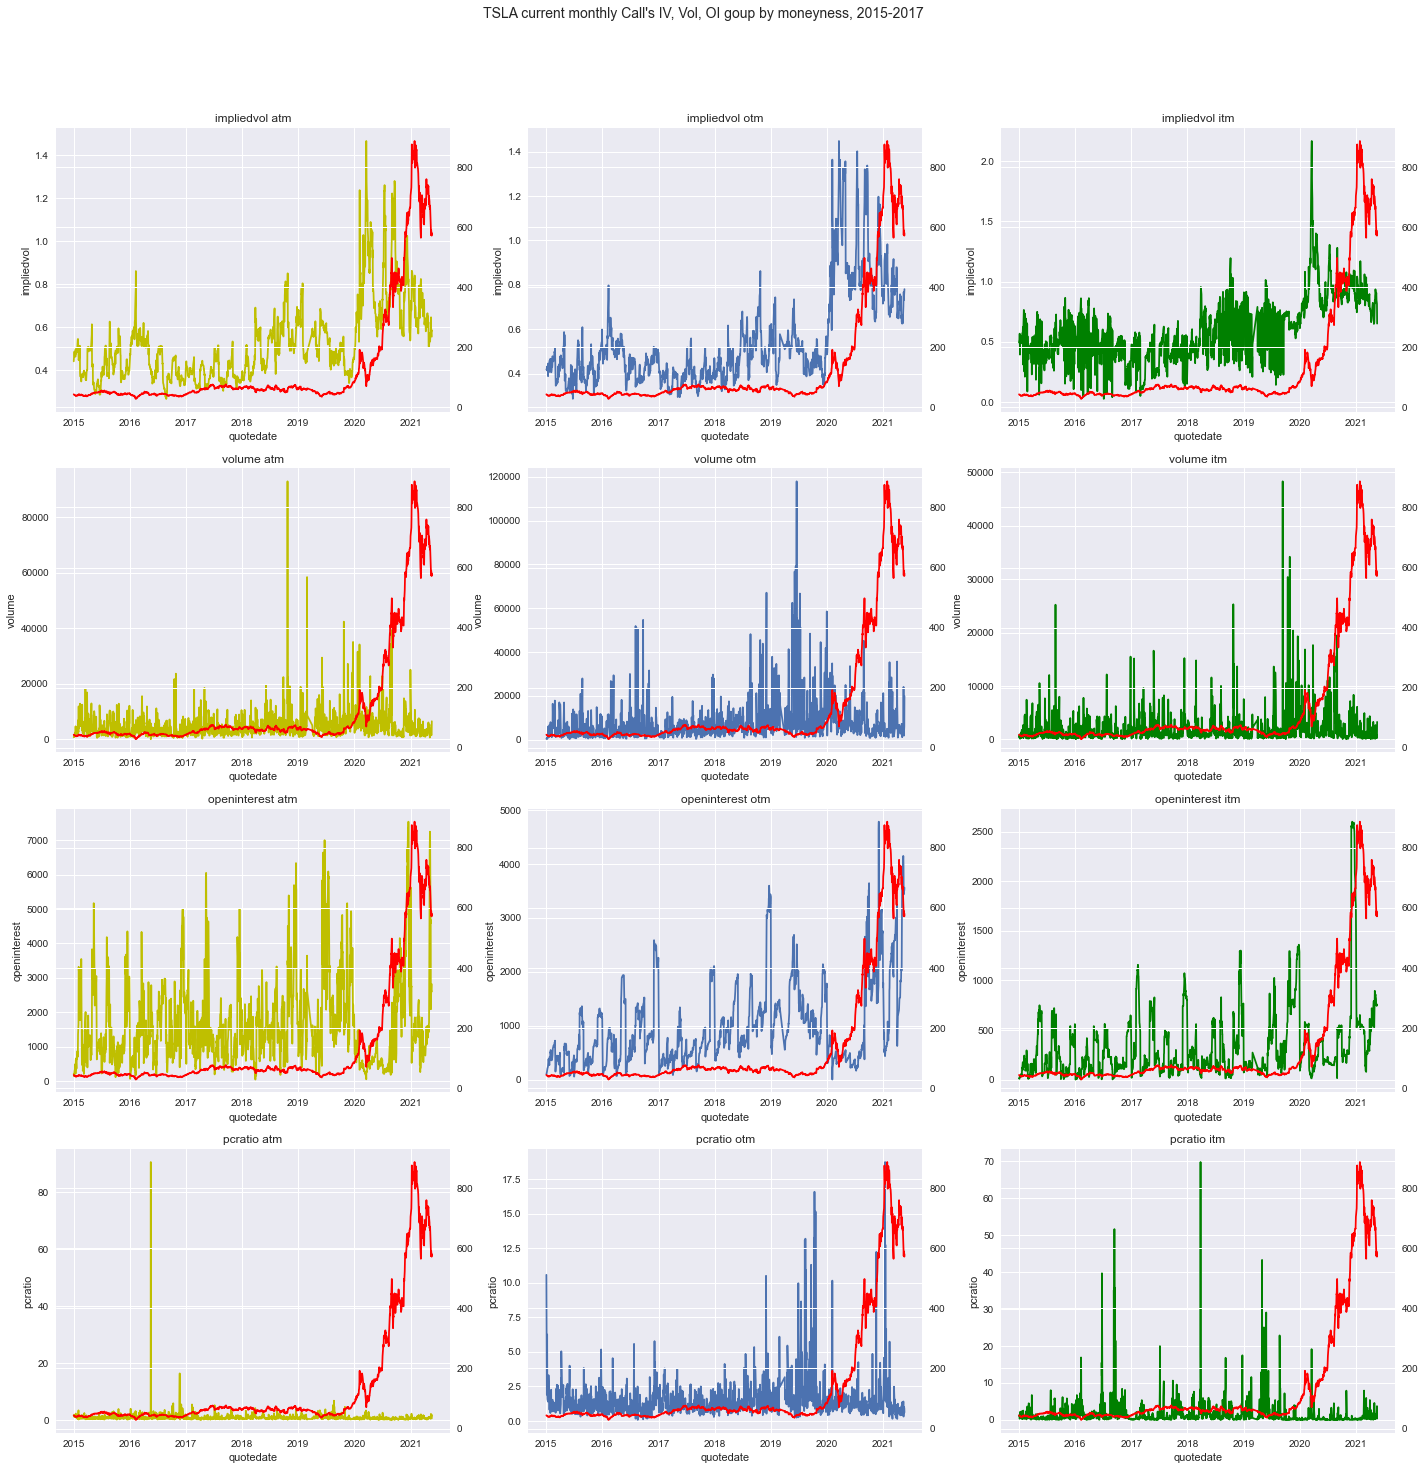

In [44]:
#monthly contract expiring in current month
title = "TSLA current monthly Call's IV, Vol, OI goup by moneyness, 2015-2017"
atm, otm, itm = plot_by_moneyness(next_month, _type='call', groupby='quotedate', 
                  variable = ['impliedvol','volume','openinterest','pcratio'], style='ts', title=title)

# Anomaly detection

In [234]:
def anomaly_dates(df, _type='call', variable=['volume','pcratio'], direction=['>','<'], 
                  thresh=[3,0.5], window=30, volume_operation='max'):
    """
    return dates in which variables exceed thresh
    """
    grouped = df[df['type']==_type].groupby('quotedate')
    conditions = []
    for i, v in enumerate(variable):
        if v=='volume':
            vol_series = grouped['volume'].agg(volume_operation)
            vol_rollingmean = vol_series.rolling(window).mean().shift()
            vol_rollingstd = vol_series.rolling(window).std().shift()
            vol_thresh = vol_rollingmean + vol_rollingstd*thresh[i]
            cond = pd.eval('vol_series' + direction[i] + 'vol_thresh') 
            
        if v=='pcratio':
            pcr = pcratio(df)
            cond = pd.eval('pcr' + direction[i] + str(thresh[i])) 
        
        if v=='openinterest':
            oi_series = grouped['openinterest'].sum()
            oi_rollingmean = oi_series.rolling(window,min_periods=1).mean().shift()
            oi_rollingstd = oi_series.rolling(window,min_periods=1).std().shift()
            oi_thresh = oi_rollingmean + oi_rollingstd*thresh[i]
            cond = pd.eval('oi_series' + direction[i] + 'oi_thresh')
            
        if v=='impliedvol':
            iv_series = grouped['impliedvol'].mean()
            iv_rolling = iv_series.rolling(window).quantile(thresh[i], interpolation='linear').shift()
            cond = pd.eval('iv_series' + direction[i] + 'iv_rolling')
        conditions.append(cond)
        
    dates = pd.concat(conditions, axis=1).all(axis=1)
    dates = dates[dates==1].index
    return dates

In [367]:
def outlier_impact(optiondata, outlier_date, win_thresh=0, verbose=True):
    price_series = optiondata.groupby('quotedate')['underlying_last'].mean()
    
    outlier_date_index = np.argwhere(np.in1d(price_series.index,outlier_date)).reshape(-1)  
    next_day_index = np.clip(outlier_date_index + 1, 0, len(price_series)-1)
    next_5day_index = np.clip(outlier_date_index + 5, 0, len(price_series)-1)

    a = price_series[outlier_date_index].reset_index(drop=True)
    b = price_series[next_day_index].reset_index(drop=True)
    c = price_series[next_5day_index].reset_index(drop=True)
    
    output = pd.concat([a,b,c],axis=1)
    output.index = outlier_date
    output.columns = ['outlierday','nextday','next5thday']
    
    next_day_return = np.log(b/a) 
    next_5thday_return = np.log(c/a)
    #avg_5thday_winprob = round((c>a).mean(),3)
    avg_5thday_winprob = round((next_5thday_return>win_thresh).mean(),3)
    avg_5thday_posreturn = round(next_5thday_return[next_5thday_return>0].mean(),3)
    avg_5thday_negreturn = round(next_5thday_return[next_5thday_return<0].mean(),3)
    avg_5thday_expreturn = avg_5thday_posreturn*avg_5thday_winprob + avg_5thday_negreturn*(1-avg_5thday_winprob)
    
    if verbose:
        print('+1 day stock price increase probability:', round((b>a).mean(),3))
        print('+1 day stock price avg increase:', round(next_day_return[next_day_return>0].mean(),3))
        print('+1 day stock price avg decrease', round(next_day_return[next_day_return<0].mean(),3),'\n')
        print('+5 day stock price increase probability:', avg_5thday_winprob)
        print('+5 day stock price avg increase:', avg_5thday_posreturn)
        print('+5 day stock price avg decrease:', avg_5thday_negreturn)
        print('+5 day expected return:', avg_5thday_expreturn)
        return output
    
    else:
        return avg_5thday_winprob, len(output), avg_5thday_posreturn, avg_5thday_negreturn, avg_5thday_expreturn

In [374]:
def optimize_threshold(df, _type='call', variable=['volume','pcratio','impliedvol'], direction=['>','<','>'], 
                       volume_operation='max', window=252, win_thresh=0, **kwargs):
    
    thresh_dic = {'volume':np.arange(1,3.1,0.1), 'pcratio':np.arange(0.5,1.6,0.1),
                  'impliedvol':np.arange(0,1,0.1), 'openinterest':np.arange(1,3.1,0.1)}
    thresh_dic = {k:v for k,v in thresh_dic.items() if k in variable}
    for key, value in kwargs.items():
        assert key in thresh_dic, f'{key} is invalid variable'
        thresh_dic[key] = value
            
    l = []
    for i, param in enumerate(itertools.product(*thresh_dic.values())):
        outlier = anomaly_dates(df, _type=_type, variable=variable, direction=direction, 
                                thresh=param, window=window, volume_operation=volume_operation)
        stats = outlier_impact(df, outlier, win_thresh=win_thresh, verbose=False)
        l.append([*stats,np.around(param,2)])
        if i%500 == 0:
            print(i)
            
    performance = pd.DataFrame(l,columns=['winprob','outliernum','posret','negret','expret','/'.join(variable)])
    return performance

def filter_threshold(performance, winprob=0.7, topn=1):
    #get top 3 winning probability entries in each group
    temp = performance[(performance['outliernum']>1) & (performance['winprob']>winprob)]
    temp = temp.sort_values(['outliernum','winprob'],ascending=[False,False]).groupby('outliernum').head(topn)
    return temp

In [294]:
def highest_volume_strike(df, date, _type='call', splitdate=None, splitratio=None):
    """
    get strike that has most volume on date
    """
    date, splitdate = pd.to_datetime(date), pd.to_datetime(splitdate)
    strike = df[(df['quotedate']==date) & (df['type']==_type)].sort_values('volume',ascending=False).iloc[0]['strike']
    if (splitdate is not None) and (date < splitdate):
        strike /= splitratio
        
    return strike

def snapshot(df, date, ticker, before=20, after=10):
    """
    plot stock price series before and after the date
    """
    start = pd.to_datetime(date) - np.timedelta64(before,'D')
    end = pd.to_datetime(date) + np.timedelta64(after,'D')
    close = get_all_price(ticker, start, end)['close']
    highest_volume_K = highest_volume_strike(df, date, _type='call', splitdate='2020-8-31', splitratio=5)
    
    fig = plt.figure()
    plt.plot(close.T)
    plt.hlines(highest_volume_K,start,end,'y',label=str(highest_volume_K))
    plt.title(date)
    plt.scatter(date,close.loc[date],c='r',marker='x')

# Test0: Find outlier between 11/2020 - 5/2021

In [45]:
start = '2019-11-01'
end = '2021-05-31'
splitdate = '2020-08-31'
splitratio = 5
optiondata = quotedate_contract(full_optiondata, start, end, splitdate, splitratio)
cur_month, next_month, third_month = monthly_contract(optiondata)
atm, otm, itm = moneyness_contract(next_month)

### Optimize Threshold

In [147]:
performance = optimize_threshold(otm)

1.0
1.5000000000000004
2.000000000000001
2.5000000000000013
3.0000000000000018


Text(0, 0.5, 'outlier number')

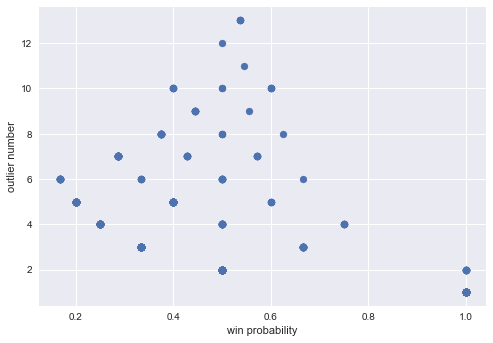

In [148]:
plt.scatter(performance['winprob'],performance['outliernum'])
plt.xlabel('win probability')
plt.ylabel('outlier number')

In [149]:
temp = performance[performance['outliernum']>1]
temp.loc[temp.groupby('outliernum')['winprob'].idxmax()]

,winprob,outliernum,posret,negret,expret,volume/pcratio/iv
3,1.000,2,0.073,NaN,NaN,"(1.0, 0.5, 0.3)"
2,0.667,3,0.073,-0.023,0.041032,"(1.0, 0.5, 0.2)"
43,0.750,4,0.061,NaN,NaN,"(1.0, 0.9, 0.3)"
11,0.600,5,0.121,-0.013,0.067400,"(1.0, 0.6, 0.1)"
42,0.667,6,0.057,-0.023,0.030360,"(1.0, 0.9, 0.2)"
21,0.571,7,0.102,-0.013,0.052665,"(1.0, 0.7, 0.1)"
41,0.625,8,0.089,-0.013,0.050750,"(1.0, 0.9, 0.1)"
51,0.556,9,0.089,-0.019,0.041048,"(1.0, 1.0, 0.1)"
61,0.600,10,0.100,-0.019,0.052400,"(1.0, 1.1, 0.1)"
40,0.545,11,0.078,-0.084,0.004290,"(1.0, 0.9, 0.0)"


In [164]:
outlier = anomaly_dates(otm, _type='call', variable=['volume','pcratio','impliedvol'], 
                         direction=['>','<','>'], thresh=[1.0, 0.9, 0.2], window=252)
outlier_impact(optiondata, outlier, verbose=True)

+1 day stock price increase probability: 0.333
+1 day stock price avg increase: 0.024
+1 day stock price avg decrease -0.018 

+5 day stock price increase probability: 0.667
+5 day stock price avg increase: 0.057
+5 day stock price avg decrease: -0.023
+5 day expected return: 0.030360000000000005


,outlierday,nextday,next5thday
quotedate,,,
2020-12-16,622.51,651.42,645.92
2021-03-09,666.79,668.18,698.18
2021-03-26,612.70,609.20,695.05
2021-03-31,668.49,659.92,682.17
2021-05-12,593.91,574.00,580.55
2021-05-18,580.55,580.55,580.55


In [159]:
outlier

DatetimeIndex(['2020-12-16', '2021-03-09', '2021-03-26', '2021-03-31',
               '2021-05-12', '2021-05-18'],
              dtype='datetime64[ns]', name='quotedate', freq=None)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


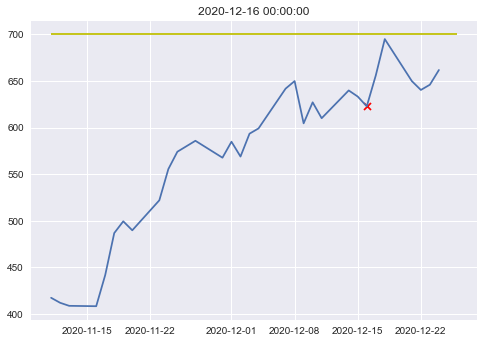

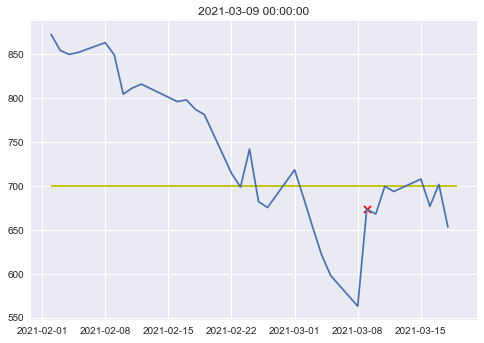

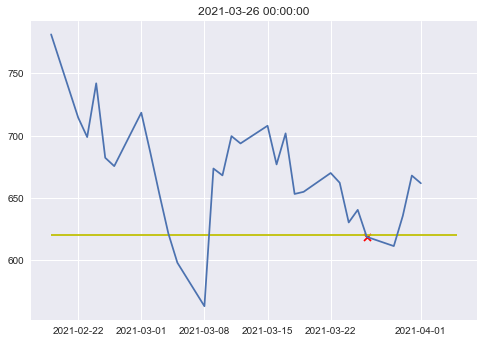

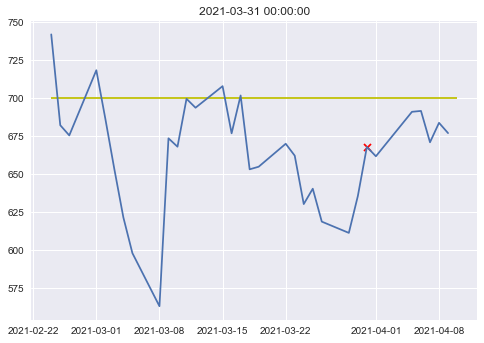

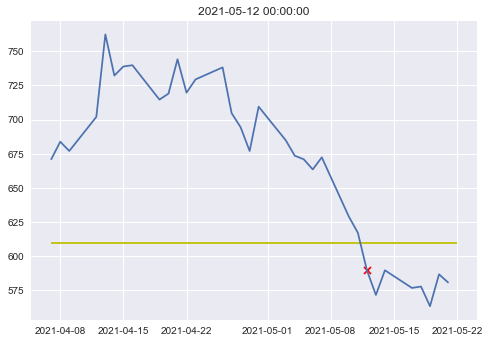

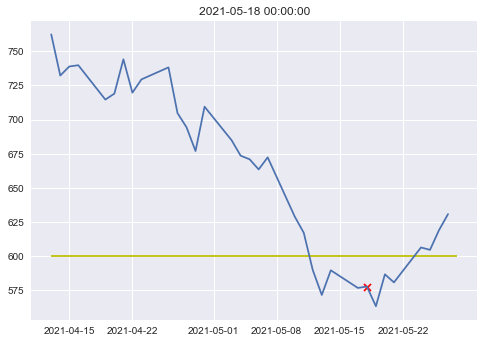

In [217]:
for date in outlier:
    snapshot(optiondata, date,'TSLA', before=35, after=10)

# Test1: Find outlier between 11/2020 - 5/2021, using mean volume

In [303]:
volume = np.arange(0,3.1,0.1)
performance1 = optimize_threshold(otm, volume=volume, volume_operation='mean')

0.0
0.5
1.0
1.5
2.0
2.5
3.0


Text(0, 0.5, 'outlier number')

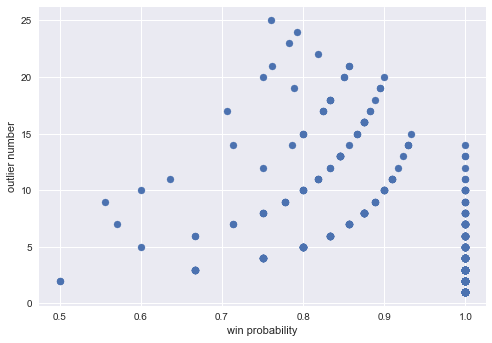

In [304]:
plt.scatter(performance1['winprob'],performance1['outliernum'])
plt.xlabel('win probability')
plt.ylabel('outlier number')

In [306]:
#get top 3 winning probability entries in each group
temp = performance1[(performance1['outliernum']>1) & (performance1['winprob']>0.7)]
temp.sort_values(['outliernum','winprob'],ascending=[False,False]).groupby('outliernum').head(1)

,winprob,outliernum,posret,negret,expret,volume/pcratio/iv
100,0.760,25,0.093,-0.064,0.055320,"(0.0, 1.5, 0.0)"
90,0.792,24,0.093,-0.071,0.058888,"(0.0, 1.4, 0.0)"
80,0.783,23,0.097,-0.071,0.060544,"(0.0, 1.3, 0.0)"
210,0.818,22,0.092,-0.030,0.069796,"(0.1, 1.5, 0.0)"
101,0.857,21,0.097,-0.019,0.080412,"(0.0, 1.5, 0.1)"
91,0.900,20,0.097,-0.019,0.085400,"(0.0, 1.4, 0.1)"
81,0.895,19,0.102,-0.019,0.089295,"(0.0, 1.3, 0.1)"
191,0.889,18,0.101,-0.019,0.087680,"(0.1, 1.3, 0.1)"
71,0.882,17,0.106,-0.019,0.091250,"(0.0, 1.2, 0.1)"
61,0.875,16,0.106,-0.019,0.090375,"(0.0, 1.1, 0.1)"


<AxesSubplot:xlabel='quotedate'>

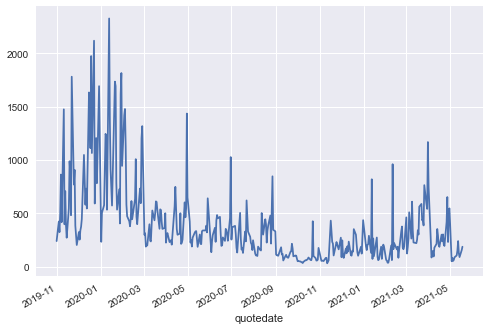

In [320]:
otm.groupby('quotedate')['volume'].mean().plot()

In [317]:
otm.groupby('quotedate')['volume'].mean().std()

371.7154804434797

In [319]:
otm.groupby('quotedate')['volume'].mean().mean()

384.2064377921396

In [324]:
outlier1 = anomaly_dates(otm, _type='call', variable=['volume','pcratio','impliedvol'], 
                         direction=['>','<','>'], thresh=[1.3, 0.9, 0.6], window=63, volume_operation='mean')
outlier_impact(otm, outlier1, verbose=True)

+1 day stock price increase probability: 0.714
+1 day stock price avg increase: 0.043
+1 day stock price avg decrease -0.016 

+5 day stock price increase probability: 0.857
+5 day stock price avg increase: 0.126
+5 day stock price avg decrease: -0.057
+5 day expected return: 0.09983099999999999


,outlierday,nextday,next5thday
quotedate,,,
2020-08-12,310.016,324.468,376.350
2020-08-13,324.468,328.644,402.194
2020-08-21,408.548,400.940,446.260
2020-08-24,400.940,403.986,497.740
2020-08-26,430.572,448.094,441.330
2020-08-28,446.260,497.740,421.420
2021-03-31,668.490,659.920,682.170


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


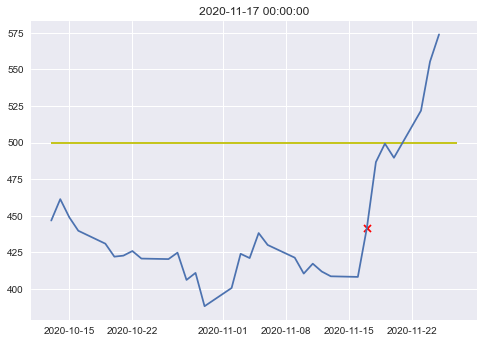

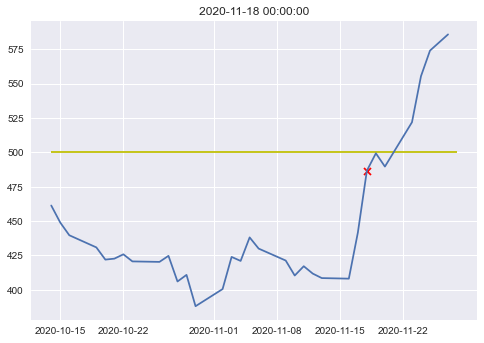

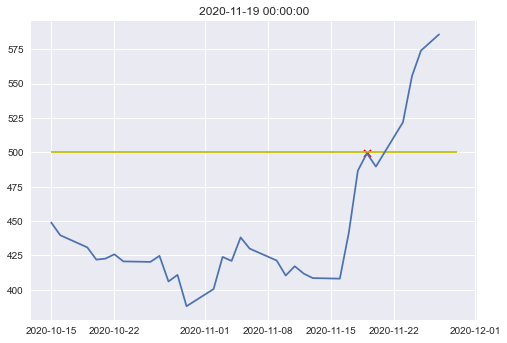

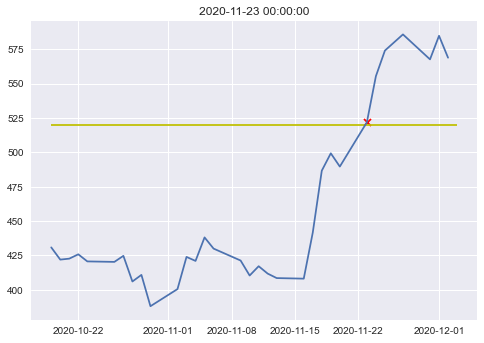

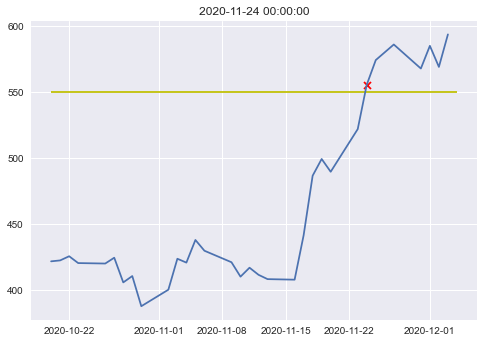

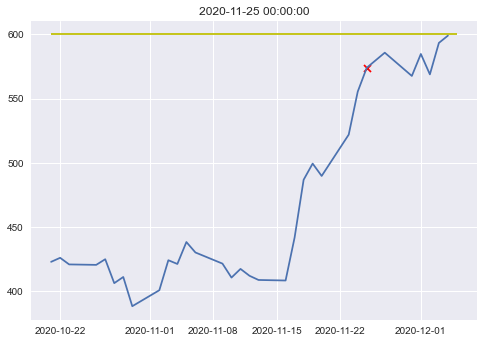

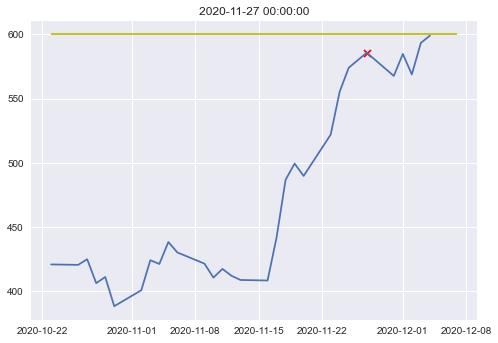

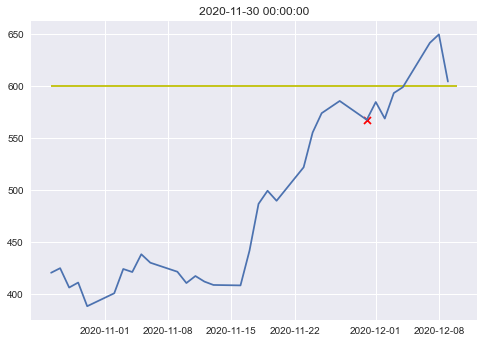

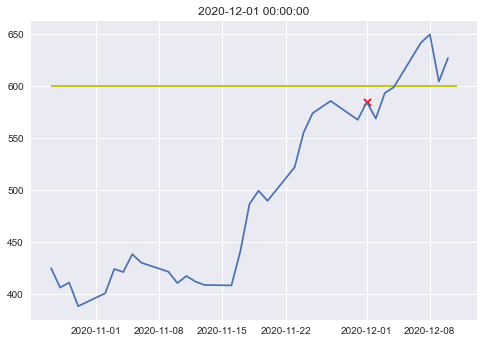

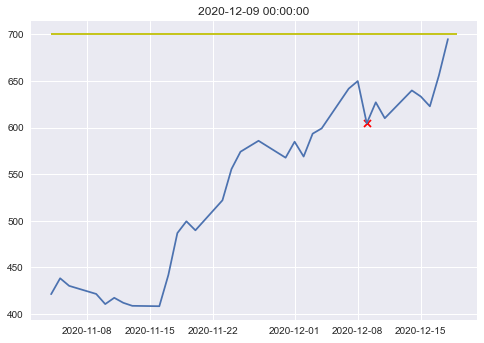

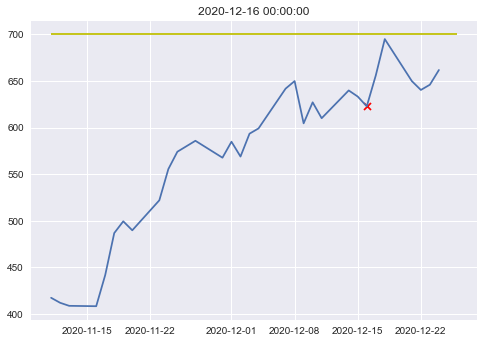

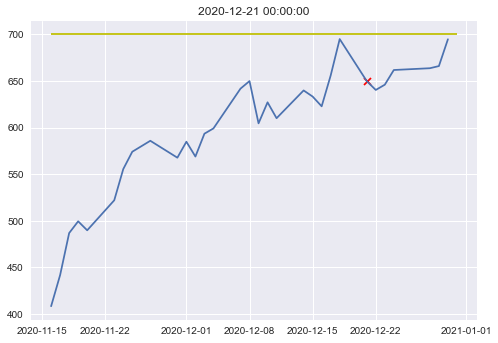

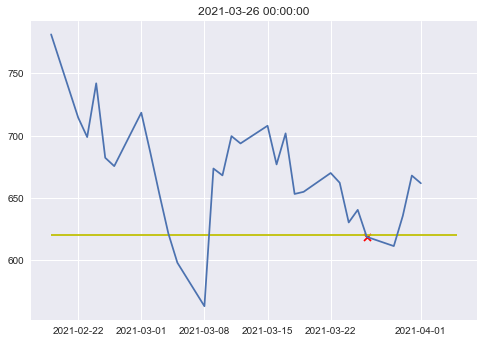

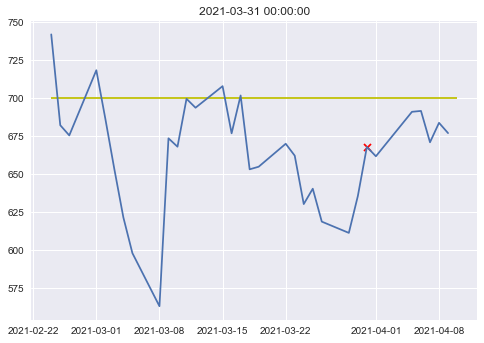

In [321]:
for date in outlier1:
    snapshot(optiondata, date,'TSLA', before=35, after=10)

# Test2: Find outlier between 1/2015 - 12/2018

In [102]:
start = '2014-01-01'
end = '2018-12-31'
splitdate = '2020-08-31'
splitratio = 5
optiondata2 = quotedate_contract(full_optiondata, start, end, splitdate, splitratio)
cur_month2, next_month2, third_month2 = monthly_contract(optiondata2)
atm2, otm2, itm2 = moneyness_contract(next_month2)

In [109]:
performance2 = optimize_threshold(otm2)

1.0
1.5000000000000004
2.000000000000001
2.5000000000000013
3.0000000000000018


Text(0, 0.5, 'outlier number')

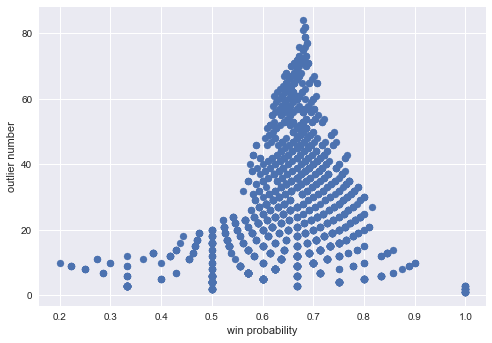

In [110]:
plt.scatter(performance2['winprob'],performance2['outliernum'])
plt.xlabel('win probability')
plt.ylabel('outlier number')

In [219]:
temp = performance2[performance2['outliernum']>1]
temp.loc[temp.groupby('outliernum')['winprob'].idxmax()].iloc[:40]

,winprob,outliernum,posret,negret,expret,volume/pcratio/iv
119,1.000,2,0.053,NaN,NaN,"(1.1, 0.5, 0.9)"
789,1.000,3,0.084,NaN,NaN,"(1.7, 0.6, 0.9)"
129,0.750,4,0.084,-0.029,0.055750,"(1.1, 0.6, 0.9)"
799,0.800,5,0.074,-0.019,0.055400,"(1.7, 0.7, 0.9)"
1599,0.833,6,0.084,-0.019,0.066799,"(2.4, 1.0, 0.9)"
1489,0.857,7,0.075,-0.019,0.061558,"(2.3, 1.0, 0.9)"
1499,0.875,8,0.081,-0.019,0.068500,"(2.3, 1.1, 0.9)"
1159,0.889,9,0.094,-0.019,0.081457,"(2.0, 1.0, 0.9)"
1169,0.900,10,0.097,-0.019,0.085400,"(2.0, 1.1, 0.9)"
798,0.727,11,0.062,-0.052,0.030878,"(1.7, 0.7, 0.8)"


In [284]:
outlier2 = anomaly_dates(otm2, _type='call', variable=['volume','pcratio','impliedvol'], 
                         direction=['>','<','>'], thresh=[1.7, 0.7, 0.5], window=252)
outlier_impact(otm2, outlier2, verbose=True)

+1 day stock price increase probability: 0.688
+1 day stock price avg increase: 0.022
+1 day stock price avg decrease -0.03 

+5 day stock price increase probability: 0.812
+5 day stock price avg increase: 0.055
+5 day stock price avg decrease: -0.052
+5 day expected return: 0.03488400000000001


,outlierday,nextday,next5thday
quotedate,,,
2016-02-10,28.7980,30.2240,33.290
2016-02-25,37.4040,38.0800,39.050
2016-03-10,40.9226,41.5100,44.900
2016-03-14,42.9860,43.6980,47.802
2016-05-05,42.2410,42.9950,41.464
2016-06-28,40.4100,42.0320,42.904
2016-10-17,38.9020,39.6620,40.556
2017-10-10,71.0880,70.9260,71.148
2017-11-02,59.8020,61.2080,60.574


In [169]:
outlier2

DatetimeIndex(['2016-02-10', '2016-02-25', '2016-03-10', '2016-03-14',
               '2016-05-05', '2016-06-28', '2016-10-17', '2017-10-10',
               '2017-11-02', '2017-12-26', '2017-12-29', '2018-01-16',
               '2018-03-27', '2018-08-17', '2018-08-30'],
              dtype='datetime64[ns]', name='quotedate', freq=None)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

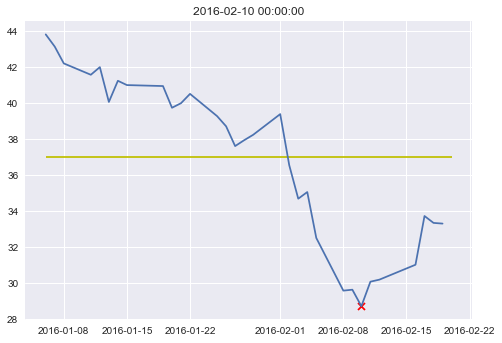

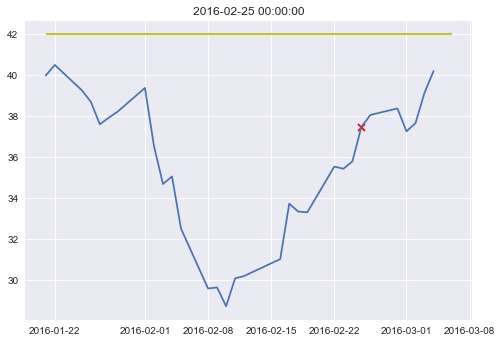

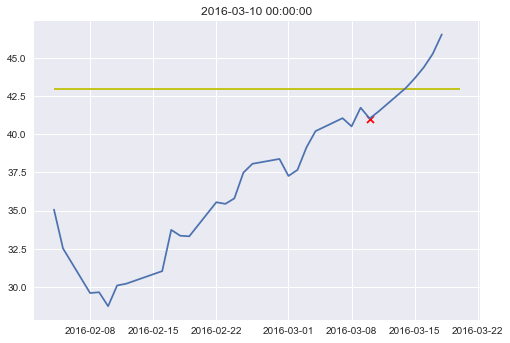

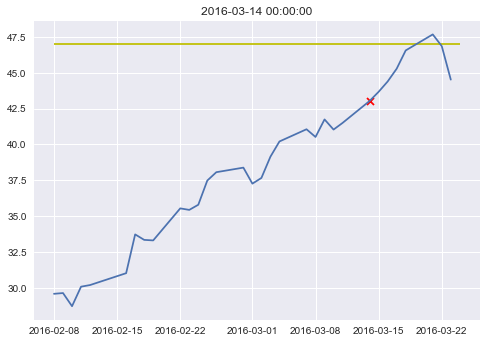

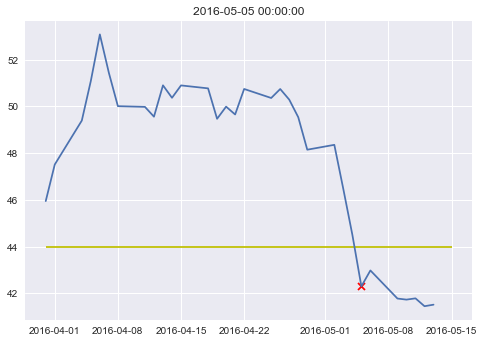

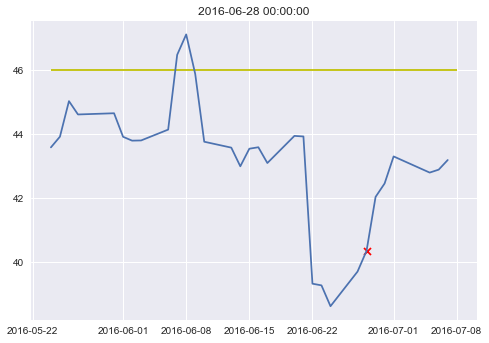

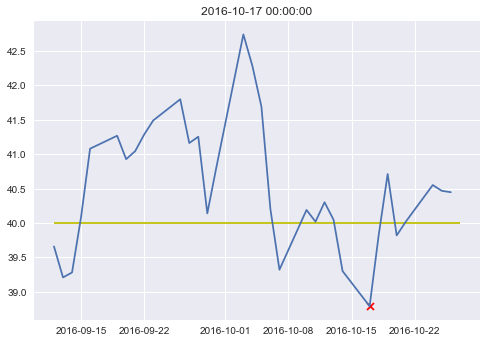

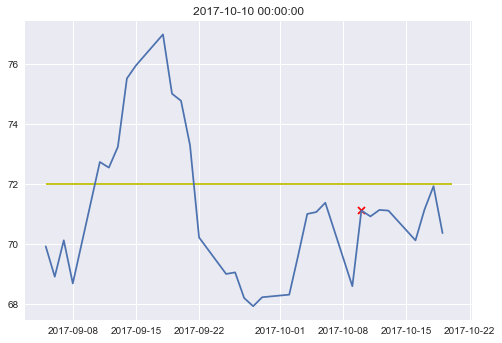

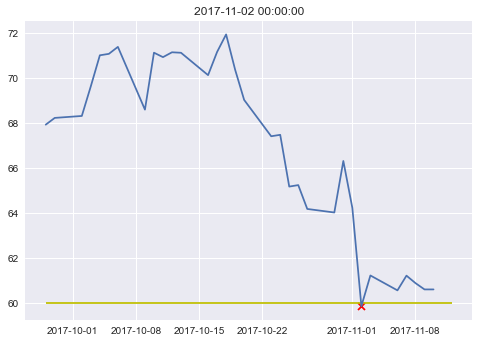

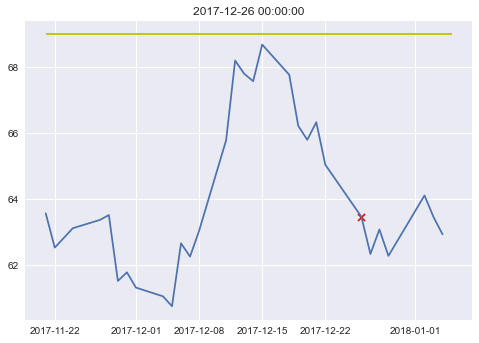

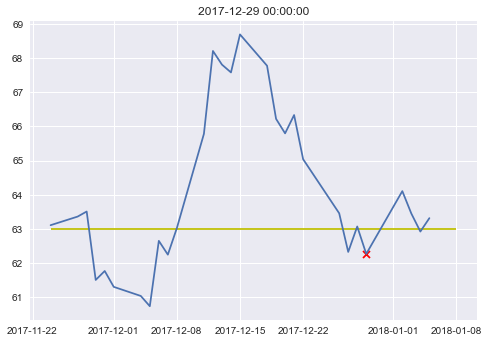

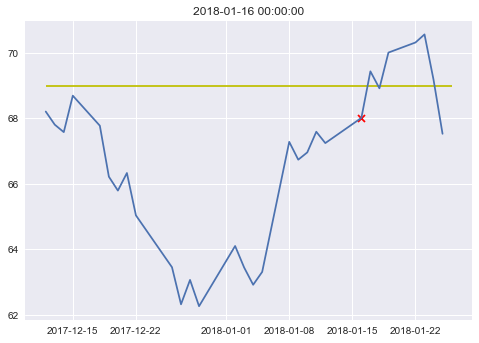

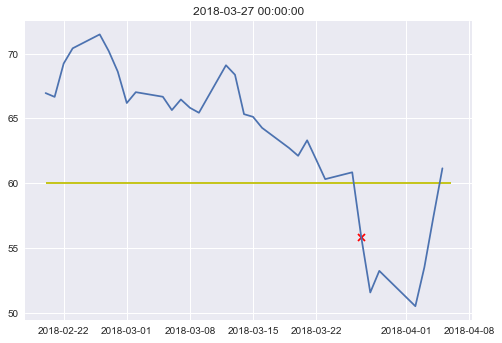

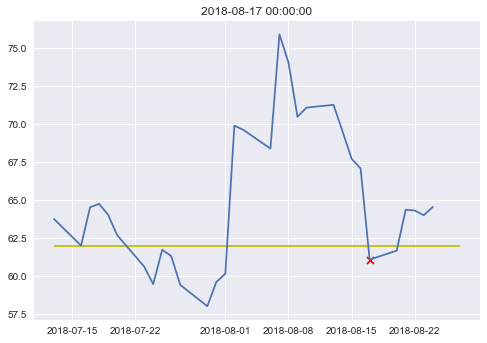

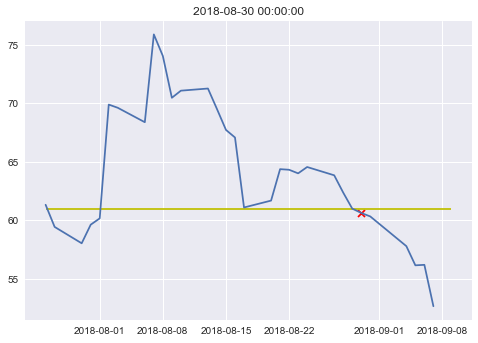

In [218]:
for date in outlier2:
    snapshot(optiondata2, date,'TSLA', before=35, after=10)

# Test3: Find outlier between 1/2015 - 12/2018, using mean volume

In [307]:
performance3 = optimize_threshold(otm2, volume_operation='mean')

1.0
1.5
2.0
2.5
3.0


Text(0, 0.5, 'outlier number')

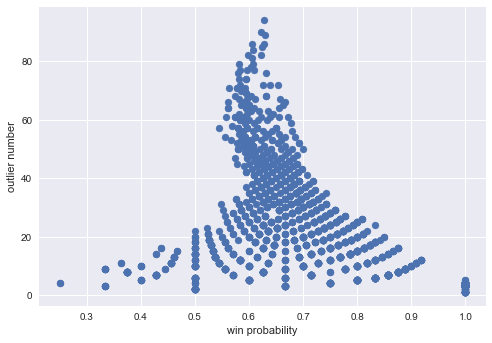

In [308]:
plt.scatter(performance3['winprob'],performance3['outliernum'])
plt.xlabel('win probability')
plt.ylabel('outlier number')

In [309]:
#get top 3 winning probability entries in each group
temp = performance3[(performance3['outliernum']>1) & (performance3['winprob']>0.7)]
temp.sort_values(['outliernum','winprob'],ascending=[False,False]).groupby('outliernum').head(1)

,winprob,outliernum,posret,negret,expret,volume/pcratio/iv
65,0.707,41,0.067,-0.048,0.033305,"(1.0, 1.1, 0.5)"
43,0.718,39,0.059,-0.053,0.027416,"(1.0, 0.9, 0.3)"
87,0.711,38,0.076,-0.052,0.039008,"(1.0, 1.3, 0.7)"
197,0.703,37,0.077,-0.052,0.038687,"(1.1, 1.3, 0.7)"
44,0.722,36,0.060,-0.055,0.028030,"(1.0, 0.9, 0.4)"
1094,0.743,35,0.077,-0.039,0.047188,"(1.9, 1.5, 0.4)"
1204,0.735,34,0.080,-0.039,0.048465,"(2.0, 1.5, 0.4)"
373,0.727,33,0.061,-0.045,0.032062,"(1.3, 0.9, 0.3)"
428,0.719,32,0.079,-0.037,0.046404,"(1.3, 1.4, 0.8)"
374,0.742,31,0.063,-0.048,0.034362,"(1.3, 0.9, 0.4)"


In [310]:
outlier3 = anomaly_dates(otm2, _type='call', variable=['volume','pcratio','impliedvol'], 
                         direction=['>','<','>'], thresh=[1.9, 0.9, 0.6], window=252, volume_operation='mean')
outlier_impact(optiondata2, outlier3, verbose=True)

+1 day stock price increase probability: 0.75
+1 day stock price avg increase: 0.025
+1 day stock price avg decrease -0.028 

+5 day stock price increase probability: 0.875
+5 day stock price avg increase: 0.077
+5 day stock price avg decrease: -0.031
+5 day expected return: 0.0635


,outlierday,nextday,next5thday
quotedate,,,
2016-03-01,37.1860,37.6240,40.5000
2016-03-02,37.6240,39.0500,41.7000
2016-03-10,40.9226,41.5100,44.9000
2016-03-14,42.9860,43.6980,47.8020
2016-03-31,45.9900,47.4700,51.4320
2016-05-05,42.2410,42.9950,41.4640
2017-11-02,59.8020,61.2080,60.5740
2017-12-26,63.4900,62.3520,63.4860
2018-02-08,63.1280,62.3360,66.6160


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

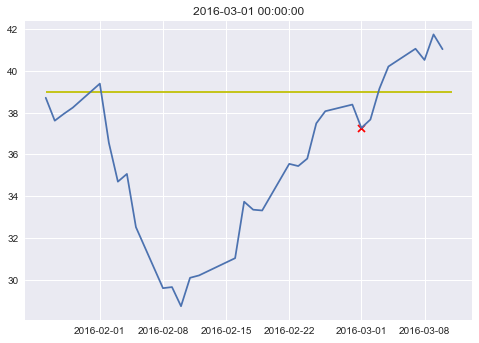

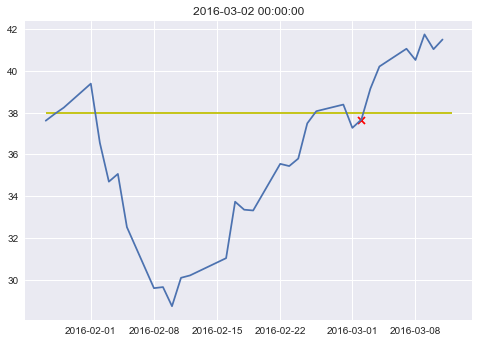

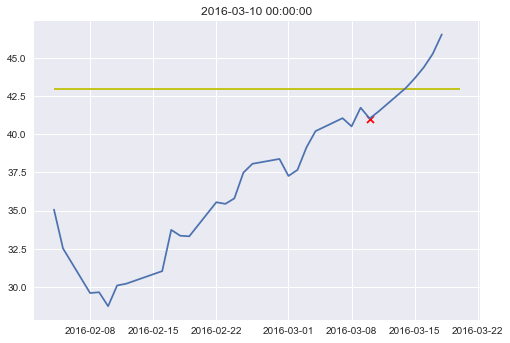

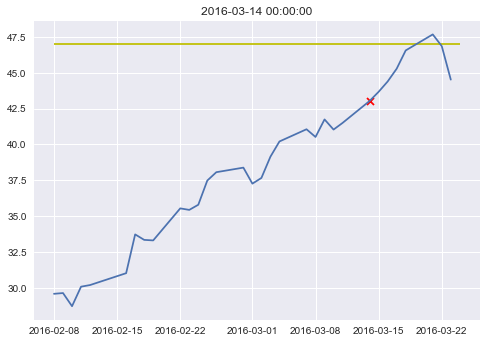

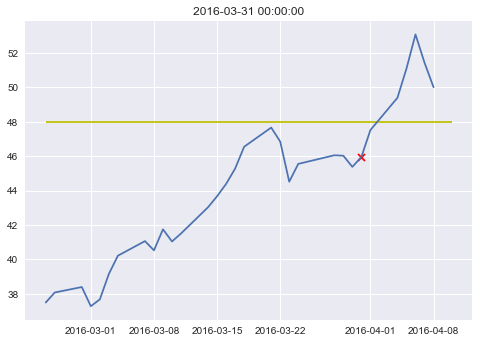

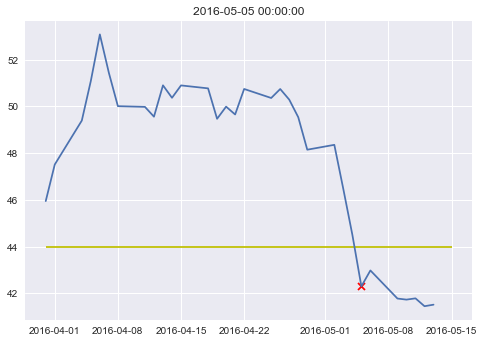

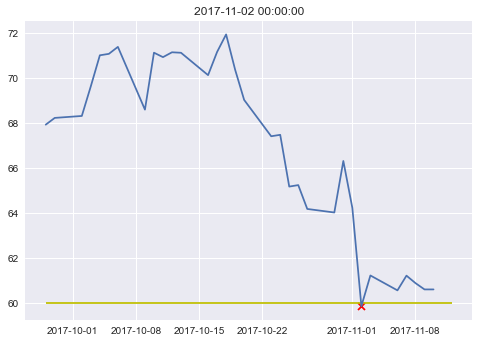

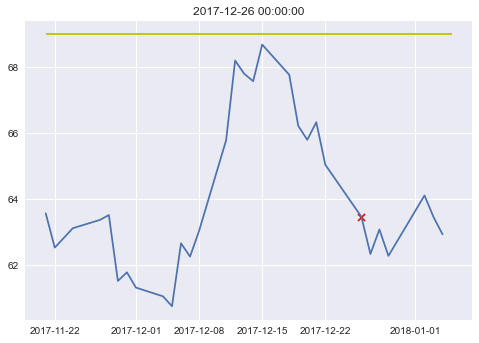

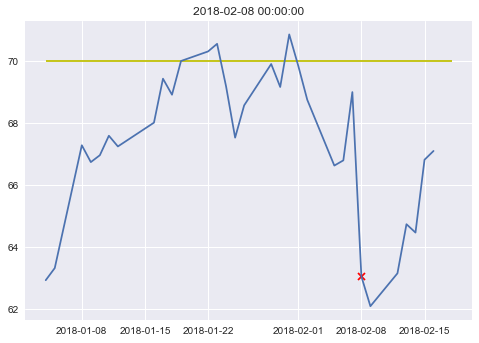

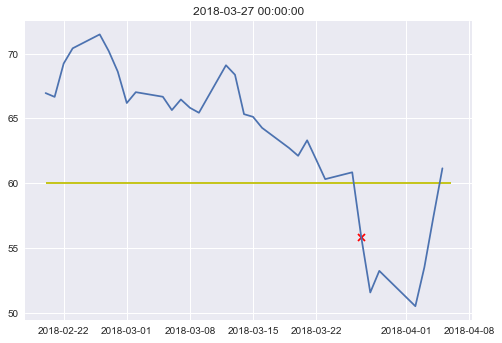

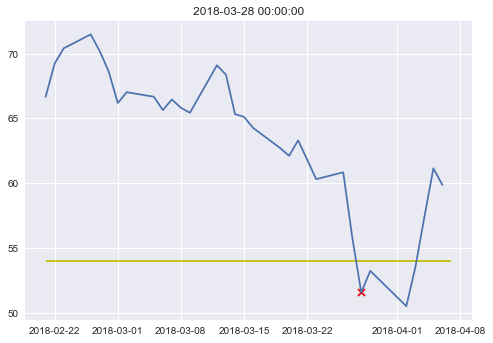

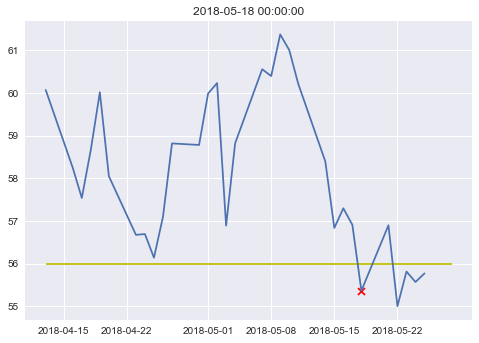

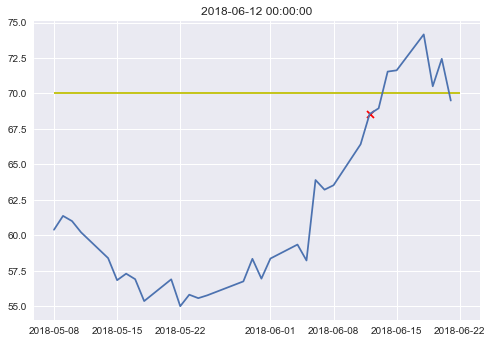

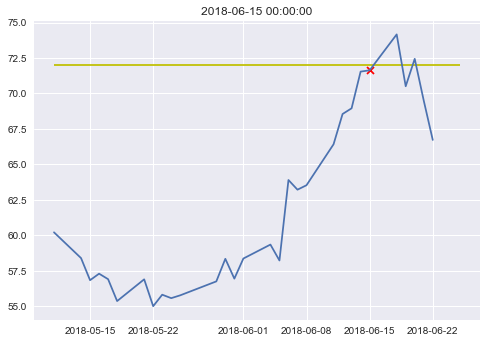

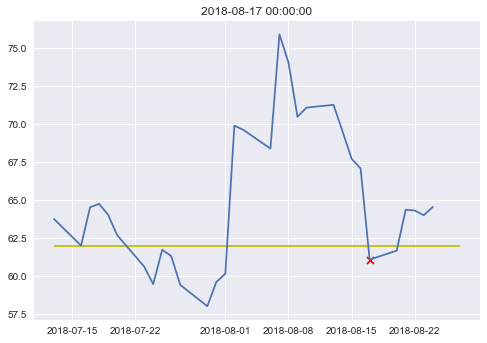

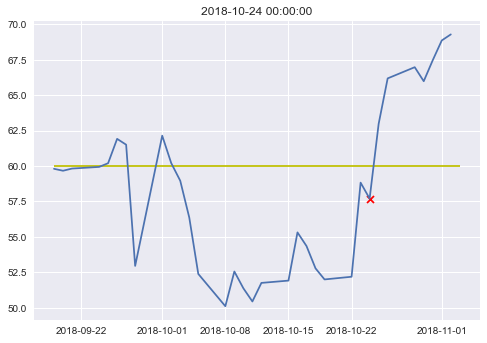

In [311]:
for date in outlier3:
    snapshot(optiondata2, date,'TSLA', before=35, after=10)